# Multimodal Clusters: DDC Spatial Coverage

This notebook demonstrates DDC's advantage in **clustered data** with multiple well-separated modes. We'll show how DDC preserves cluster structure better than Random sampling.

## What You'll Learn

- DDC preserves cluster structure better than Random
- Spatial coverage matters for clustered data
- How to interpret coverage metrics

## The Dataset

We'll use a **Gaussian mixture with 6 clusters** of varying sizes. This demonstrates DDC's ability to ensure all clusters are represented, even small ones.

## 1. Setup

In [1]:
# Install dd-coresets (uncomment if needed)
# !pip install dd-coresets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available, using PCA for visualization")

from dd_coresets import fit_ddc_coreset, fit_random_coreset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

UMAP not available, using PCA for visualization


## 2. Generate Dataset

We'll create a Gaussian mixture with **6 clusters** of varying sizes.

In [3]:
# Generate Gaussian mixture with imbalanced clusters
n_samples = 15000
n_features = 10
n_clusters = 6

# Cluster sizes: [5000, 3000, 2000, 2000, 1500, 1500]
cluster_sizes = [5000, 3000, 2000, 2000, 1500, 1500]

X_list = []
labels_list = []

for i, size in enumerate(cluster_sizes):
    X_cluster, _ = make_blobs(
        n_samples=size,
        n_features=n_features,
        centers=1,
        cluster_std=1.2,
        center_box=(-15, 15),
        random_state=RANDOM_STATE + i
    )
    # Offset each cluster
    offset = np.array([i * 8, 0] + [0] * (n_features - 2))
    X_cluster += offset
    X_list.append(X_cluster)
    labels_list.append(np.full(size, i))

X = np.vstack(X_list)
cluster_labels = np.concatenate(labels_list)

# Shuffle
indices = np.random.permutation(len(X))
X = X[indices]
cluster_labels = cluster_labels[indices]

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Dataset shape: {X.shape}")
print(f"Number of clusters: {n_clusters}")
print(f"\nCluster sizes:")
for i in range(n_clusters):
    size = np.sum(cluster_labels == i)
    print(f"  Cluster {i}: {size:,} samples ({size/len(X):.1%})")

Dataset shape: (15000, 10)
Number of clusters: 6

Cluster sizes:
  Cluster 0: 5,000 samples (33.3%)
  Cluster 1: 3,000 samples (20.0%)
  Cluster 2: 2,000 samples (13.3%)
  Cluster 3: 2,000 samples (13.3%)
  Cluster 4: 1,500 samples (10.0%)
  Cluster 5: 1,500 samples (10.0%)


## 3. Fit Coresets

We'll create coresets using DDC and Random sampling with `k=300` representatives.

In [4]:
k = 300

print("Fitting coresets...")
print("=" * 60)

# DDC
S_ddc, w_ddc, info_ddc = fit_ddc_coreset(
    X, k=k, random_state=RANDOM_STATE
)
print(f"✓ DDC: {len(S_ddc)} representatives")

# Random
S_random, w_random, info_random = fit_random_coreset(
    X, k=k, random_state=RANDOM_STATE + 1
)
print(f"✓ Random: {len(S_random)} representatives")
print("=" * 60)

Fitting coresets...


✓ DDC: 300 representatives
✓ Random: 300 representatives


## 4. Compute Spatial Coverage

We'll compute how many coreset points are in each cluster.

![Cluster coverage comparison](../_images/cluster_coverage.png)

*Cluster coverage visualization showing how DDC ensures all clusters are represented.*


In [5]:
# Find cluster labels for coreset points
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X)

_, idx_ddc = nn.kneighbors(S_ddc)
_, idx_random = nn.kneighbors(S_random)

labels_ddc = cluster_labels[idx_ddc.flatten()]
labels_random = cluster_labels[idx_random.flatten()]

# Count points per cluster
coverage_ddc = {}
coverage_random = {}

for cluster_id in range(n_clusters):
    n_cluster = np.sum(cluster_labels == cluster_id)
    n_ddc = np.sum(labels_ddc == cluster_id)
    n_random = np.sum(labels_random == cluster_id)
    
    coverage_ddc[cluster_id] = n_ddc / k
    coverage_random[cluster_id] = n_random / k
    
    print(f"Cluster {cluster_id} ({n_cluster:,} samples, {n_cluster/len(X):.1%}):")
    print(f"  DDC:    {n_ddc:3d} points ({coverage_ddc[cluster_id]:.1%})")
    print(f"  Random: {n_random:3d} points ({coverage_random[cluster_id]:.1%})")

Cluster 0 (5,000 samples, 33.3%):
  DDC:    196 points (65.3%)
  Random: 111 points (37.0%)
Cluster 1 (3,000 samples, 20.0%):
  DDC:     48 points (16.0%)
  Random:  51 points (17.0%)
Cluster 2 (2,000 samples, 13.3%):
  DDC:     19 points (6.3%)
  Random:  35 points (11.7%)
Cluster 3 (2,000 samples, 13.3%):
  DDC:     19 points (6.3%)
  Random:  37 points (12.3%)
Cluster 4 (1,500 samples, 10.0%):
  DDC:      7 points (2.3%)
  Random:  45 points (15.0%)
Cluster 5 (1,500 samples, 10.0%):
  DDC:     11 points (3.7%)
  Random:  21 points (7.0%)


## 5. Visualizations

Let's visualize the coresets and their spatial coverage.

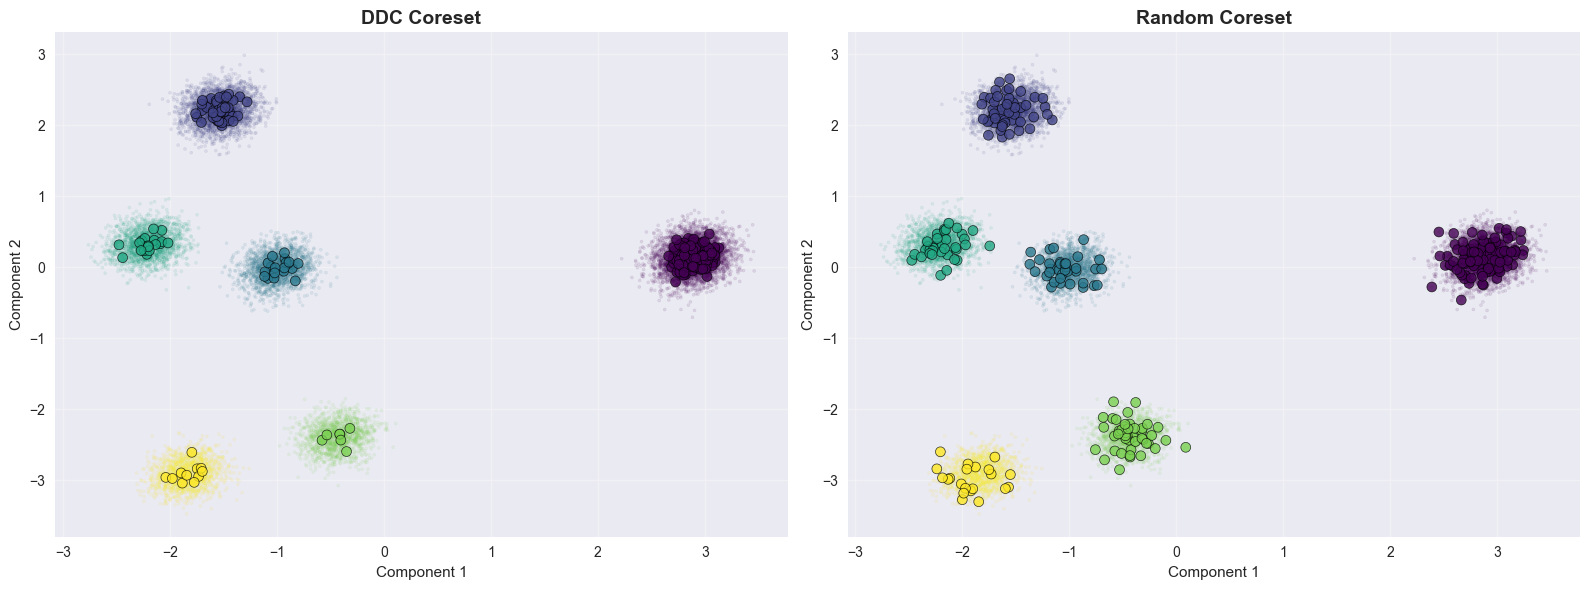

In [6]:
# Project to 2D
if HAS_UMAP:
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
else:
    reducer = PCA(n_components=2, random_state=RANDOM_STATE)

X_2d = reducer.fit_transform(X)
S_ddc_2d = reducer.transform(S_ddc)
S_random_2d = reducer.transform(S_random)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, S_2d, labels, title in zip(
    axes, [S_ddc_2d, S_random_2d],
    [labels_ddc, labels_random],
    ['DDC Coreset', 'Random Coreset']
):
    # Background: full data
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
              cmap='viridis', alpha=0.1, s=5)
    # Coreset points
    scatter = ax.scatter(S_2d[:, 0], S_2d[:, 1], c=labels,
                        cmap='viridis', s=50, alpha=0.8, 
                        edgecolors='black', linewidths=0.5)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

![Spatial coverage metrics bar chart](../_images/spatial_coverage_metrics.png)

*Spatial coverage metrics comparing minimum and mean distances to nearest representatives.*


### Spatial Coverage: Why It Matters

When data has multiple clusters of varying sizes, **spatial coverage** becomes crucial. Random sampling may miss small clusters entirely, especially when k (number of representatives) is small relative to the number of clusters.

**DDC's guarantee**: The diversity term in DDC's selection score ensures that representatives are well-distributed across all clusters. This is similar to facility location problems, where we want to place k facilities to serve all regions.

**Mathematical intuition**: The selection score combines density (p(x)^α) and diversity (distance^(1-α)). The diversity term prevents selecting points too close to already-selected representatives, naturally ensuring spatial coverage.

See [Algorithm Overview](../concepts/algorithm.md) for the mathematical details.

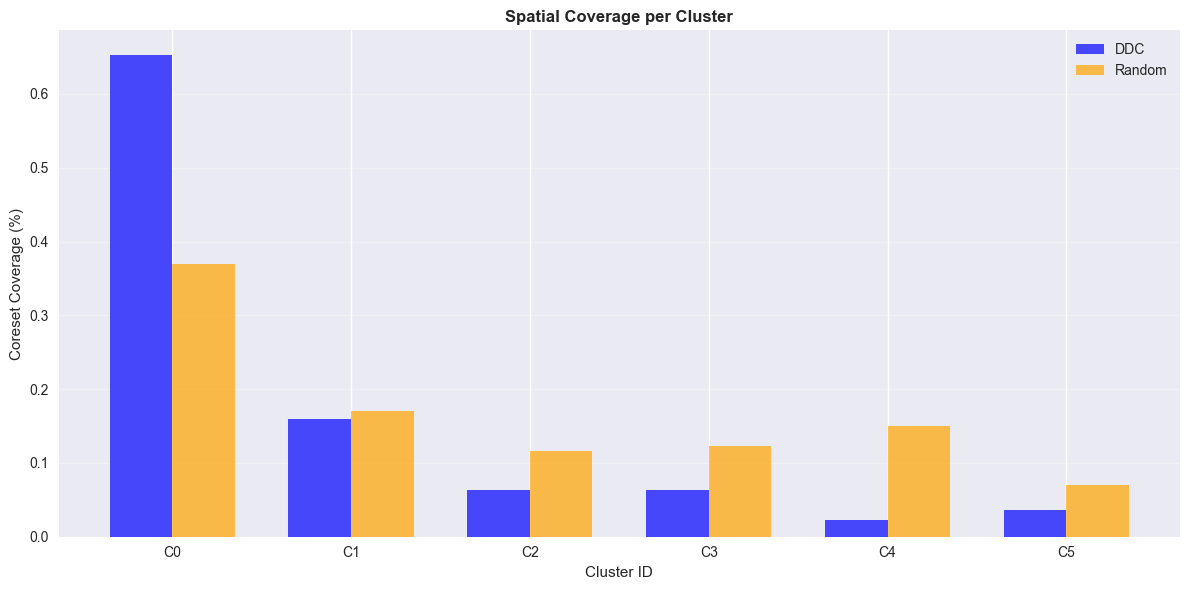

In [7]:
# Coverage comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(n_clusters)
width = 0.35

ddc_vals = [coverage_ddc[i] for i in range(n_clusters)]
random_vals = [coverage_random[i] for i in range(n_clusters)]

ax.bar(x - width/2, ddc_vals, width, label='DDC', alpha=0.7, color='blue')
ax.bar(x + width/2, random_vals, width, label='Random', alpha=0.7, color='orange')

ax.set_xlabel('Cluster ID')
ax.set_ylabel('Coreset Coverage (%)')
ax.set_title('Spatial Coverage per Cluster', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'C{i}' for i in range(n_clusters)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Key Takeaways

### When DDC is Better

- **Clustered data**: DDC ensures all clusters are represented
- **Imbalanced clusters**: DDC covers small clusters better than Random
- **Spatial coverage**: DDC guarantees coverage of all modes

### Next Steps

- Try `adaptive_distances.ipynb` for advanced features
- Try `label_aware_classification.ipynb` for supervised problems
- See `docs/DDC_ADVANTAGE_CASES.md` for comprehensive analysis